# Exoplanets: primary transit

In this example, we show how archNEMESIS can be used to perform a retrieval of an exoplanet atmosphere through the analysis of transit observations. Specifically, in this example we are first going to generate a synthetic spectrum, and then retrieve the abundance of SO$_2$ from the spectra, simulating how we would analyse a measured spectrum from an observatory.

The information about the reference classes here is obtained from an input HDF5 file with relevant information for the observation. This file can be easily generated following this [tutorial](https://archnemesis.readthedocs.io/en/latest/examples/Exoplanet_primary_transit/exoplanet.html).

In [1]:
import archnemesis as ans
import numpy as np
import matplotlib.pyplot as plt

## 1. Generating the synthetic spectrum

In this example, we are going to read the information from the input file. However, we are going to modify the amount of SO$_2$ to generate the synthetic spectrum, to see whether we can then recover it when performing the retrieval.

### 1.1. Reading the input file 

In [2]:
runname = "exoplanet"

#Reading the input files
Atmosphere,Measurement,Spectroscopy,Scatter,Stellar,Surface,CIA,Layer,Variables,Retrieval,Telluric = ans.Files.read_input_files_hdf5(runname)

INFO :: read_apr :: Variables_0.py-823 :: 
Variables_0 :: read_apr :: varident [9 0 2]. Constructed model "Model2" (id=2)
INFO :: read_apr :: Variables_0.py-826 ::   Model2:
  |- id : 2
  |- parent classes: PreRTModelBase
  |- description: In this model, the atmospheric parameters are scaled using a
  |               single factor with  respect to the vertical profiles in the
  |               reference atmosphere
  |- n_state_vector_entries : 1
  |- state_vector_slice : slice(0, 1, None)
  |- state_vector_start : 0
  |- target : 0
  |- Parameters:
  |  |- scaling_factor :
  |  |  |- slice : slice(0, 1, None)
  |  |  |- unit : PROFILE_TYPE
  |  |  |- description: Scaling factor applied to the reference profile
  |  |  |- apriori value : 1.0


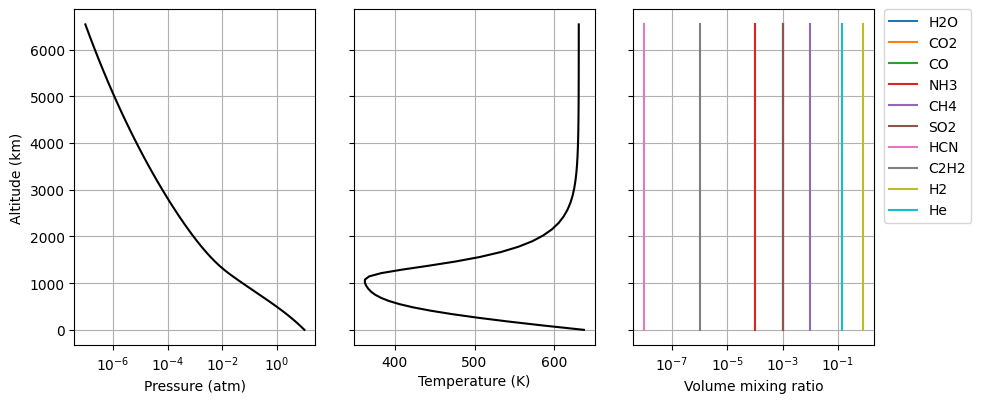

In [3]:
Atmosphere.plot_Atm()

### 1.2. Modifying the amount of SO$_2$

To modify the amount of SO$_2$ in the atmosphere, we are going to write a new .apr file, so that the reference classes are updated when computing the forward model

In [4]:
#Writing new .apr file
nvar = 1
varident = np.zeros((3,nvar),dtype="int32")
varident[:,0] = [9,0,2]   #I1=9 (SO2); I2=0 (All isotopes); I3=0 (Model 2 - scaling factor)
fapr = open(runname+".apr","w")
fapr.write("#Synthetic retrieval for exoplanet primary transit \n")
fapr.write("\t %i \n" % (nvar))
fapr.write("\t %i \t %i \t %i \n" % (varident[0,0],varident[1,0],varident[2,0]))
fapr.write("1.0 0.1 \n")
fapr.close()

In [5]:
runname = "exoplanet"

#Reading the input files
Atmosphere,Measurement,Spectroscopy,Scatter,Stellar,Surface,CIA,Layer,Variables,Retrieval,Telluric = ans.Files.read_input_files_hdf5(runname)

INFO :: read_apr :: Variables_0.py-823 :: 
Variables_0 :: read_apr :: varident [9 0 2]. Constructed model "Model2" (id=2)
INFO :: read_apr :: Variables_0.py-826 ::   Model2:
  |- id : 2
  |- parent classes: PreRTModelBase
  |- description: In this model, the atmospheric parameters are scaled using a
  |               single factor with  respect to the vertical profiles in the
  |               reference atmosphere
  |- n_state_vector_entries : 1
  |- state_vector_slice : slice(0, 1, None)
  |- state_vector_start : 0
  |- target : 0
  |- Parameters:
  |  |- scaling_factor :
  |  |  |- slice : slice(0, 1, None)
  |  |  |- unit : PROFILE_TYPE
  |  |  |- description: Scaling factor applied to the reference profile
  |  |  |- apriori value : 1.0


### 1.2. Generating a forward model

In [6]:
ForwardModel = ans.ForwardModel_0(Atmosphere=Atmosphere,Surface=Surface,Measurement=Measurement,Spectroscopy=Spectroscopy,Stellar=Stellar,Scatter=Scatter,CIA=CIA,Layer=Layer,Variables=Variables,Telluric=Telluric)

SPECONV = ForwardModel.nemesisPTfm()

INFO :: __init__ :: ForwardModel_0.py-256 :: Checking atmospheric gasses have spectroscopy data.
# WARNING #########################################################################

The following atmospheric gasses ARE NOT PRESENT in the spectroscopy data and WILL NOT CONTRIBUTE TO OPACITY:

    C2H2 (id 26) isotopologue 0
    H2 (id 39) isotopologue 0
    He (id 40) isotopologue 0

To deactivate this warning place a path to a k-table file for these gasses in one of the following locations (depending upon your input file type):

    [HDF5 Input]
        In the "wasp121.h5" file, add an entry to "/Spectroscopy/LOCATION"
        and update "/Spectroscopy/NGAS" appropriately.

    [LEGACY Input]
        Add an entry to the "wasp121.kls" file.

# END WARNING #####################################################################
INFO :: nemesisPTfm :: ForwardModel_0.py-1809 :: Calculating forward model for primary transit observation
INFO :: nemesisPTfm :: ForwardModel_0.py-1837 :: Running C

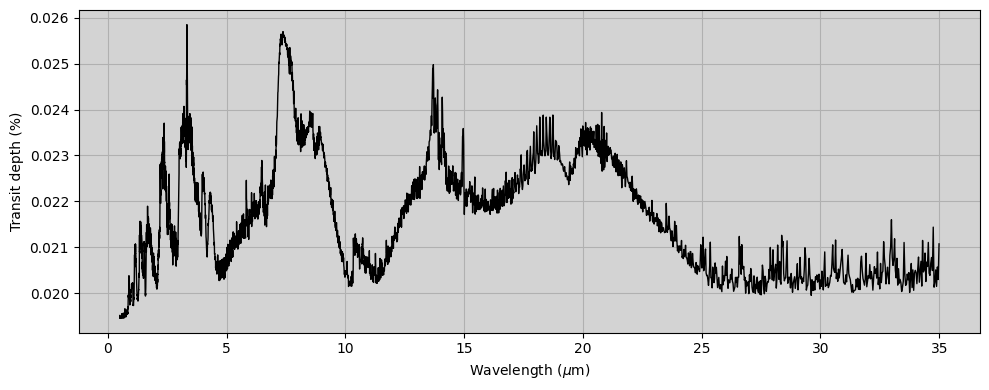

In [7]:
fig,ax1 = plt.subplots(1,1,figsize=(10,4))

ax1.plot(Measurement.VCONV[:,0],SPECONV,c='black',linewidth=1.)
ax1.grid()
ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_ylabel('Transit depth (%)')
ax1.set_facecolor('lightgray')
plt.tight_layout()


### 1.3. Adding random noise to the spectrum

Now, we add some random noise to the spectrum. This will of course be dependent on the quality of the observation. Here, we are going to assume we have a 2$\%$ error at all wavelengths.


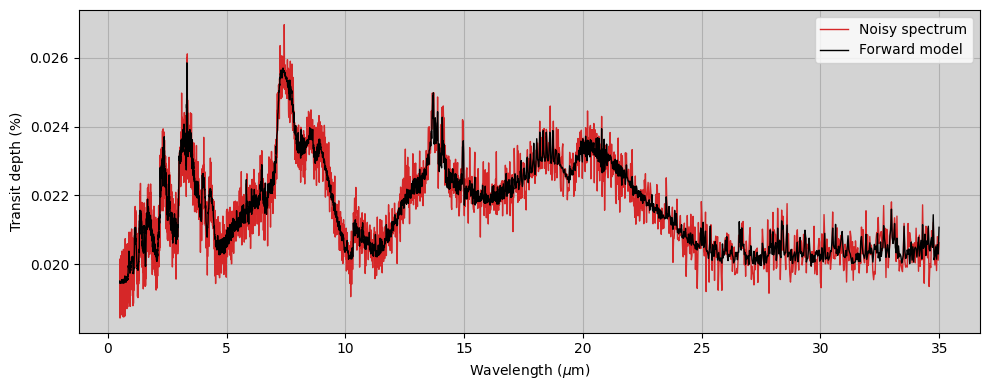

In [8]:
noise_level = 0.02 

noise = np.random.normal(loc=0.0,scale=noise_level * SPECONV[:,0])

synthetic_spectrum = (SPECONV.T + noise).T
synthetic_error = SPECONV * noise_level

fig,ax1 = plt.subplots(1,1,figsize=(10,4))

ax1.plot(Measurement.VCONV[:,0],synthetic_spectrum,c='tab:red',linewidth=1.,label="Noisy spectrum")
ax1.plot(Measurement.VCONV[:,0],SPECONV,c='black',linewidth=1.,label="Forward model")
ax1.grid()
ax1.legend()
ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_ylabel('Transit depth (%)')
ax1.set_facecolor('lightgray')
plt.tight_layout()

### 1.4. Re-writing file

Now we need to overwrite the Measurement class to include the measured spectrum and uncertainty in the input file.

In [9]:
Measurement.edit_MEAS(synthetic_spectrum)
Measurement.edit_ERRMEAS(synthetic_error)

Measurement.write_hdf5(runname)

## 2. Running the retrieval

Now that we have a "measured" spectrum, we can perform a retrieval to see if we can recover a given atmospheric parameter. In our case, we are going to retrieve a continuous vertical profile of SO$_2$. To do so, we are going to specify this information in the .apr file, and then we will perform the retrieval.

### 2.1. Writing .apr file 

In [16]:
def write_apr_continuous_profile(filename,press,profile,profile_err,clen=1.5):
    """
    Function to write the a priori file for the retrieval of a continuous vertical profile
    """

    #Write file
    fref = open(filename,'w')
    fref.write('\t %i \t %10.3f \n' % (len(press),clen))
    for i in range(len(press)):
        fref.write('\t %10.6e \t %10.6e \t %10.6e \n' % (press[i],profile[i],profile_err[i]))
    fref.close()


#Writing new .apr file
nvar = 1
varident = np.zeros((3,nvar),dtype="int32")
varident[:,0] = [9,0,0]   #I1=9 (SO2); I2=0 (All isotopes); I3=0 (Model 0 - continuous profile)
fapr = open(runname+".apr","w")
fapr.write("#Synthetic retrieval for exoplanet primary transit \n")
fapr.write("\t %i \n" % (nvar))
fapr.write("\t %i \t %i \t %i \n" % (varident[0,0],varident[1,0],varident[2,0]))
fapr.write("so2apr.dat \n")
fapr.close()

#Writing the so2apr.dat file
so2_apr = np.ones(Atmosphere.NP) * 1.0e-2
so2_aprerr = so2_apr * 0.5   #50% uncertainty
write_apr_continuous_profile("so2apr.dat",Atmosphere.P,so2_apr,so2_aprerr,clen=1.5)


### 2.2. Setting up retrieval

In [21]:
Retrieval = ans.OptimalEstimation_0(IRET=0)

Retrieval.NITER = 5       #Number of iterations
Retrieval.PHILIMIT = 0.1   #Convergence criterion
Retrieval.NCORES = 1       #Number of available cores (not needed for this version of the forward model)

Retrieval.assess_input()
Retrieval.write_input_hdf5(runname)

### 2.3. Running retrieval

In [22]:
legacy_files=False   #Reading the HDF5 file 
retrieval_method=0   #Optimal Estimtion
NCores=None          #Since we are not including scattering in this calculation (Scatter.ISCAT=0), the Jacobian is calculated analytically
nemesisPT=True       #We indicate that the retrieval must be run using the primary transit forward model

ans.Retrievals.retrieval_nemesis(runname,legacy_files=legacy_files,retrieval_method=retrieval_method,NCores=NCores,nemesisPT=nemesisPT)

INFO :: read_apr :: Variables_0.py-823 :: 
Variables_0 :: read_apr :: varident [9 0 0]. Constructed model "Model0" (id=0)
INFO :: read_apr :: Variables_0.py-826 ::   Model0:
  |- id : 0
  |- parent classes: PreRTModelBase
  |- description: In this model, the atmospheric parameters are modelled as
  |               continuous profiles in which each element of the state vector
  |               corresponds to the atmospheric profile  at each altitude level
  |- n_state_vector_entries : 50
  |- state_vector_slice : slice(0, 50, None)
  |- state_vector_start : 0
  |- target : 0
  |- Parameters:
  |  |- full_profile :
  |  |  |- slice : slice(None, None, None)
  |  |  |- unit : PROFILE_TYPE
  |  |  |- description: Every value for each level of the profile
  |  |  |- apriori value : [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 

## 3. Exploring the outputs

### 3.1. Reading the fitted spectrum

In [26]:
Measurement = ans.Files.read_bestfit_hdf5(runname)

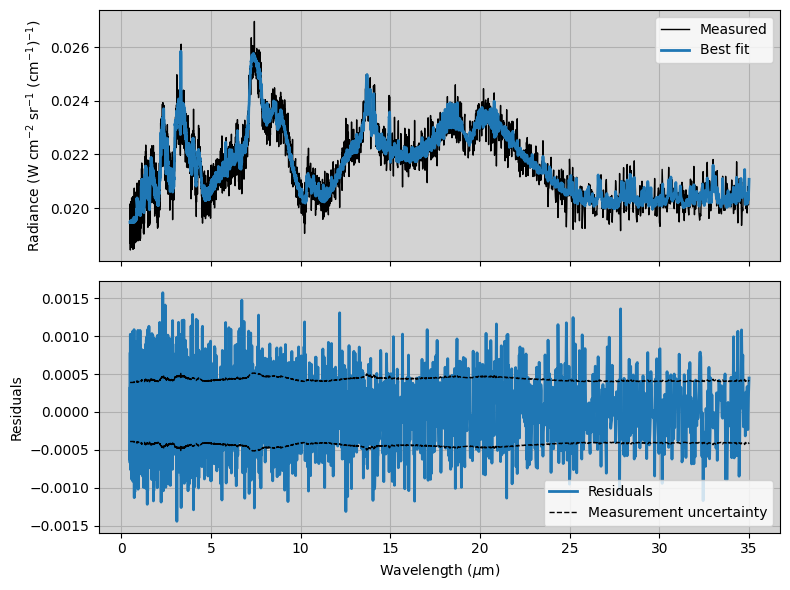

In [27]:
#Making summary plot
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,6),sharex=True)


ax1.plot(Measurement.VCONV,Measurement.MEAS,label='Measured',c='black',linewidth=1)
ax1.plot(Measurement.VCONV,Measurement.SPECMOD,label='Best fit',linewidth=2.)

ax2.plot(Measurement.VCONV,Measurement.SPECMOD-Measurement.MEAS,linewidth=2.,label='Residuals')
ax2.plot(Measurement.VCONV,Measurement.ERRMEAS,c='black',linewidth=1,label='Measurement uncertainty',linestyle='--')
ax2.plot(Measurement.VCONV,-Measurement.ERRMEAS,c='black',linewidth=1,linestyle='--')
ax2.legend()

ax1.grid()
ax2.grid()
ax1.legend()
ax1.set_facecolor('lightgray')
ax2.set_facecolor('lightgray')
ax2.set_xlabel('Wavelength ($\mu$m)')
ax1.set_ylabel('Radiance (W cm$^{-2}$ sr$^{-1}$ (cm$^{-1}$)$^{-1}$)')
ax2.set_ylabel('Residuals')
plt.tight_layout()

### 3.2. Reading the retrieved parameters

In [28]:
nvar,nxvar,varident,varparam,aprparam,aprerrparam,retparam,reterrparam = ans.Files.read_retparam_hdf5(runname)

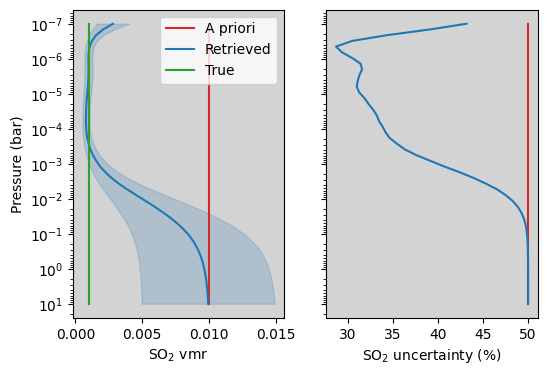

In [49]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(6,4),sharey=True)

ivar = 0

capr = "tab:red"
cret = "tab:blue"
ctrue = "tab:green"

ax1.plot(aprparam[:,ivar],Atmosphere.P/1.0e5,label="A priori",c=capr)
ax1.fill_betweenx(Atmosphere.P/1.0e5,retparam[:,ivar]-reterrparam[:,ivar],retparam[:,ivar]+reterrparam[:,ivar],alpha=0.2,color=cret)
ax1.plot(retparam[:,ivar],Atmosphere.P/1.0e5,label="Retrieved",c=cret)
ax1.plot(Atmosphere.VMR[:,Atmosphere.ID==9],Atmosphere.P/1.0e5,label="True",c=ctrue)
ax1.set_facecolor("lightgray")
ax1.set_ylabel("Pressure (bar)")
ax1.set_yscale("log")
ax1.set_xlabel("SO$_2$ vmr")
plt.gca().invert_yaxis()

ax2.plot(aprerrparam[:,ivar]/aprparam[:,ivar]*100.,Atmosphere.P/1.0e5,label="A priori",c=capr)
ax2.plot(reterrparam[:,ivar]/retparam[:,ivar]*100.,Atmosphere.P/1.0e5,label="Retrieved",c=cret)
ax2.set_facecolor("lightgray")
ax2.set_xlabel("SO$_2$ uncertainty (%)")

ax1.legend()